In [1]:
#install.packages("emmeans")
library(DHARMa)
library(lindia)
library(tidyverse)
library(caret)
library(leaps)
library(MASS)
library(modEvA)
library(dplyr)
library(lme4) #random effect
library(broom)
library(ggpubr) 
library(rstatix)
library(WRS2) #robust ancova
library(lmerTest) #like lmer but with p-value
library(emmeans) #visualize interaction term

#levenetest
library(car)

library(rstanarm) #r2 in mixed effect models
library(performance) #r2 in mixed effect models

This is DHARMa 0.3.3.0. For overview type '?DHARMa'. For recent changes, type news(package = 'DHARMa') Note: Syntax of plotResiduals has changed in 0.3.0, see ?plotResiduals for details

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.3
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift



Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':



# Download data

In [40]:
#path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/chapter0_final_/visual/Treatment&Classs/adaptability/chapter0_final__percentgaeHensNotMovingTreatment.csv'
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/correctlightschedule_/visual/Treatment&Classs/adaptability'
df = read.csv(file.path(path_,'STATInterIntraDifferences.csv'), header = TRUE, sep = ";")
#df = read.csv(file.path(path_,'STATpercentgaeHensNotMovingTreatmentPenmonth1.csv'), header = TRUE, sep = ";")
#df$SQRTPercentagenotmoving <- sqrt(df$Percentagenotmoving)
df$Treatment = as.factor(df$Treatment) 
df$PenID = as.factor(df$PenID)
df$henID1 = as.factor(df$henID1)
df$henID2 = as.factor(df$henID2)
df$inter_intra = as.factor(df$inter_intra)
df$DIB = as.integer(df$DIB) #as factor as within a week its not th etime taht we want to take into acount, but the event
df$HenID1_CLASS = as.factor(df$HenID1_CLASS)
df$HenID2_CLASS = as.factor(df$HenID2_CLASS)
df$sqrtchi2distance = sqrt(df$chi2distance)
name = 'firsttry'
print(dim(df))
summary(df)
head(df, 3)

[1] 11918    46


       X              DIB             DOA        Treatment       henID1     
 Min.   :    0   Min.   : 1.00   Min.   :119.0   OFH :5810   hen_10 :   96  
 1st Qu.: 2979   1st Qu.:19.00   1st Qu.:137.0   TRAN:6108   hen_108:   96  
 Median : 5958   Median :30.00   Median :148.0               hen_111:   96  
 Mean   : 5958   Mean   :29.72   Mean   :147.7               hen_112:   96  
 3rd Qu.: 8938   3rd Qu.:42.00   3rd Qu.:160.0               hen_117:   96  
 Max.   :11917   Max.   :53.00   Max.   :171.0               hen_118:   96  
                                                             (Other):11342  
     henID2      inter_intra      PenID      HenID1_CLASS HenID2_CLASS
 hen_118:  108   inter:5959   pen10  :1728   LEXP :2336   LEXP :2283  
 hen_69 :  107   intra:5959   pen11  :1728   MEXP :3334   MEXP :3399  
 hen_9  :  107                pen12  :1516   Other:6248   Other:6236  
 hen_143:  106                pen8   :1472                            
 hen_99 :  106               

,X,DIB,DOA,Treatment,henID1,henID2,inter_intra,PenID,HenID1_CLASS,HenID2_CLASS,...,max_nbr_stays_5_Zone,min_nbr_stays_2_Zone,max_nbr_stays_2_Zone,min_nbr_stays_1_Zone,max_nbr_stays_1_Zone,min_nbr_stays_5_Zone_cat,max_nbr_stays_5_Zone_cat,X5_Zone_is_samerange,is_only_other,sqrtchi2distance
,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,0,1,119,OFH,hen_102,hen_102,intra,pen3,MEXP,MEXP,...,2,0,2,0,0,0-4,0-4,True,False,0.3591534
2,1,1,119,OFH,hen_104,hen_102,inter,pen3,Other,MEXP,...,3,0,4,0,0,0-4,0-4,True,False,0.4711644
3,2,1,119,OFH,hen_102,hen_94,inter,pen3,MEXP,LEXP,...,2,0,2,0,0,0-4,0-4,True,False,0.3591534


In [41]:
df_NOMEXP = df[ which(df$is_only_other=='True'), ]
summary(df_NOMEXP)

       X              DIB             DOA        Treatment       henID1    
 Min.   :   13   Min.   : 1.00   Min.   :119.0   OFH :2252   hen_87 :  84  
 1st Qu.: 3025   1st Qu.:19.00   1st Qu.:137.0   TRAN:2426   hen_118:  80  
 Median : 5962   Median :30.00   Median :148.0               hen_14 :  77  
 Mean   : 5964   Mean   :29.73   Mean   :147.7               hen_22 :  77  
 3rd Qu.: 8936   3rd Qu.:42.00   3rd Qu.:160.0               hen_108:  76  
 Max.   :11916   Max.   :53.00   Max.   :171.0               hen_112:  76  
                                                             (Other):4208  
     henID2     inter_intra      PenID     HenID1_CLASS HenID2_CLASS
 hen_118:  85   inter:1554   pen11  :837   LEXP :   0   LEXP :   0  
 hen_111:  81   intra:3124   pen8   :634   MEXP :   0   MEXP :   0  
 hen_62 :  80                pen10  :623   Other:4678   Other:4678  
 hen_87 :  79                pen4   :607                            
 hen_112:  78                pen12  :562       

# Mixed effect models

#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_5_Zone ~ max_5Z_cat + min_5Z_cat + DIB*is_same_ind + Treatment + (1|PenID/henID1), data=df)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)

In [ ]:
Both DIB and inter_intra are important, but the contribution of DIB depends on the level of inter_intra

In [27]:
all(is.na(df$min_nbr_stays_5_Zone))

[1] FALSE

In [ ]:
#with only non mexp
#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_5_Zone ~ min_nbr_stays_5_Zone + max_nbr_stays_5_Zone + DIB + inter_intra + DIB*inter_intra + Treatment + (1|PenID/henID1) + (1|factor(DIB)), 
           data=df_NOMEXP)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
fit

In [ ]:
summary(fit)

In [ ]:
anova(fit)

#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_5_Zone ~ min_nbr_stays_5_Zone + max_nbr_stays_5_Zone + DIB + inter_intra + DIB*inter_intra + Treatment + (1|PenID/henID1) + (1|factor(DIB)) + (1|HenID1_CLASS) + (1|HenID2_CLASS), data=df)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)

In [ ]:
emmeans(fit, pairwise ~ inter_intra : DIB, pbkrtest.limit = 4678, lmerTest.limit = 4678)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11918' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11918)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11918' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11918)' or larger];
but be warned that this may result in large computation time and memory use.



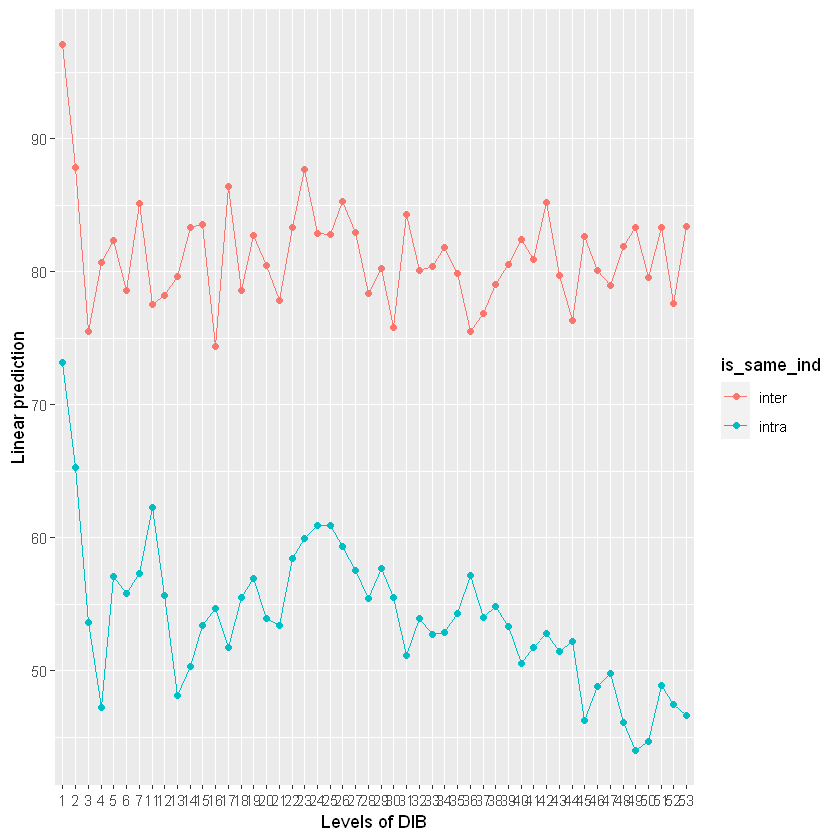

In [70]:
emmip(fit, is_same_ind~DIB)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11918' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11918)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11918' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11918)' or larger];
but be warned that this may result in large computation time and memory use.



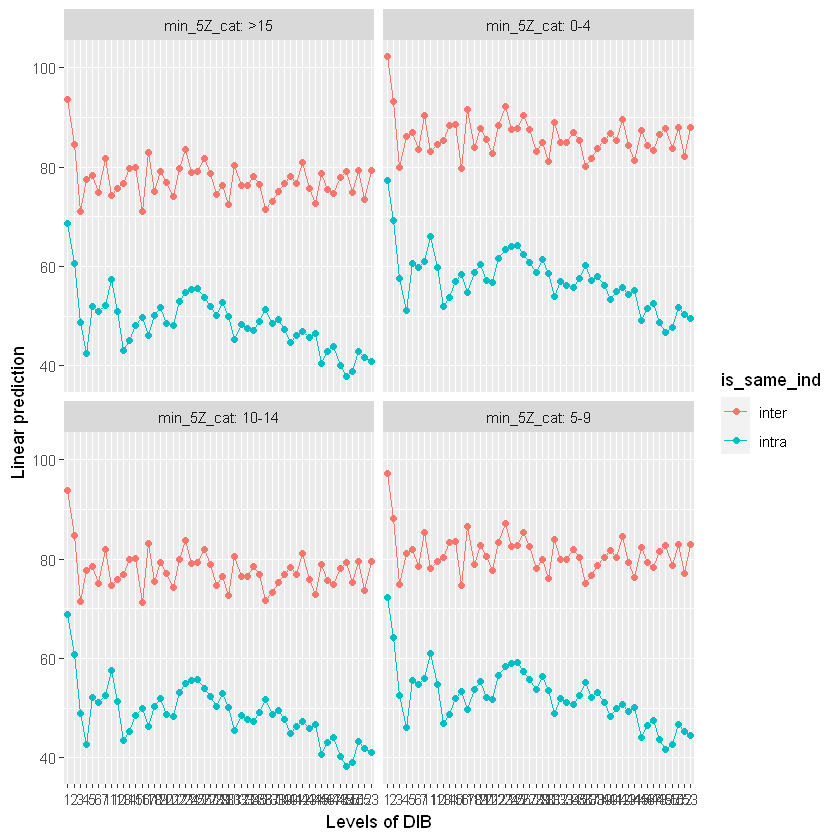

In [66]:
emmip(fit, is_same_ind~DIB|min_5Z_cat)

In [53]:
#EMM: if trnasforamtion is performed, then look: https://cran.r-project.org/web/packages/emmeans/vignettes/transformations.html

In [67]:
#estimated marginal means
#explanations: https://cran.r-project.org/web/packages/emmeans/vignettes/basics.html
#the reference grid for this model (basis for EMM computations)
ref_grid(fit) #, pbkrtest.limit = 12000, lmerTest.limit = 12000)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11918' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11918)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11918' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11918)' or larger];
but be warned that this may result in large computation time and memory use.



 max_5Z_cat min_5Z_cat DIB is_same_ind is_MEXP Treatment prediction   SE  df
 >15        >15        1   inter       False   OFH             94.6 5.17 Inf
 0-4        >15        1   inter       False   OFH             86.5 5.38 Inf
 10-14      >15        1   inter       False   OFH             94.4 5.39 Inf
 5-9        >15        1   inter       False   OFH             91.4 5.38 Inf
 >15        0-4        1   inter       False   OFH            103.3 3.54 Inf
 0-4        0-4        1   inter       False   OFH             95.2 3.11 Inf
 10-14      0-4        1   inter       False   OFH            103.1 3.27 Inf
 5-9        0-4        1   inter       False   OFH            100.1 3.17 Inf
 >15        10-14      1   inter       False   OFH             94.8 3.63 Inf
 0-4        10-14      1   inter       False   OFH             86.7 3.54 Inf
 10-14      10-14      1   inter       False   OFH             94.7 3.49 Inf
 5-9        10-14      1   inter       False   OFH             91.6 3.54 Inf

In [28]:
#estimate the mean at each point in the reference grid with std error and CI
emmeans(fit, 'DIB')

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11905' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11905' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.

NOTE: Results may be misleading due to involvement in interactions



 DIB emmean   SE  df asymp.LCL asymp.UCL
 1     87.5 2.96 Inf      81.7      93.3
 2     78.6 2.94 Inf      72.8      84.4
 3     65.8 3.93 Inf      58.1      73.5
 4     65.3 3.93 Inf      57.6      73.0
 5     71.2 3.83 Inf      63.7      78.7
 6     68.7 3.83 Inf      61.2      76.3
 7     72.7 2.94 Inf      66.9      78.5
 11    71.6 3.27 Inf      65.2      78.0
 12    69.7 3.28 Inf      63.3      76.2
 13    65.9 3.28 Inf      59.5      72.4
 14    68.2 3.28 Inf      61.7      74.6
 15    70.1 2.92 Inf      64.4      75.8
 16    65.9 2.93 Inf      60.2      71.7
 17    70.3 2.93 Inf      64.6      76.1
 18    68.8 2.92 Inf      63.1      74.5
 19    71.2 2.91 Inf      65.5      76.9
 20    68.7 2.91 Inf      63.0      74.4
 21    66.5 2.92 Inf      60.7      72.2
 22    72.3 2.92 Inf      66.5      78.0
 23    74.8 2.88 Inf      69.2      80.5
 24    72.6 2.89 Inf      66.9      78.2
 25    72.8 2.89 Inf      67.1      78.4
 26    73.3 2.87 Inf      67.7      78.9
 27    70.8 2.90

In [ ]:
#The results of ref_grid() or emmeans() (these are objects of class emmGrid) may be plotted in two different ways. One is an 
#interaction-style plot, using emmip()
#emmip(fit, is_same_ind~DIB, CIs=TRUE, pbkrtest.limit = 12000)

In [20]:
#estimate the mean at each point in the reference grid
emmip(fit, 'DIB')

ERROR: Error in formula.character(object, env = baseenv()): invalid formula "DIB": not a call


Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11905' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11905' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.



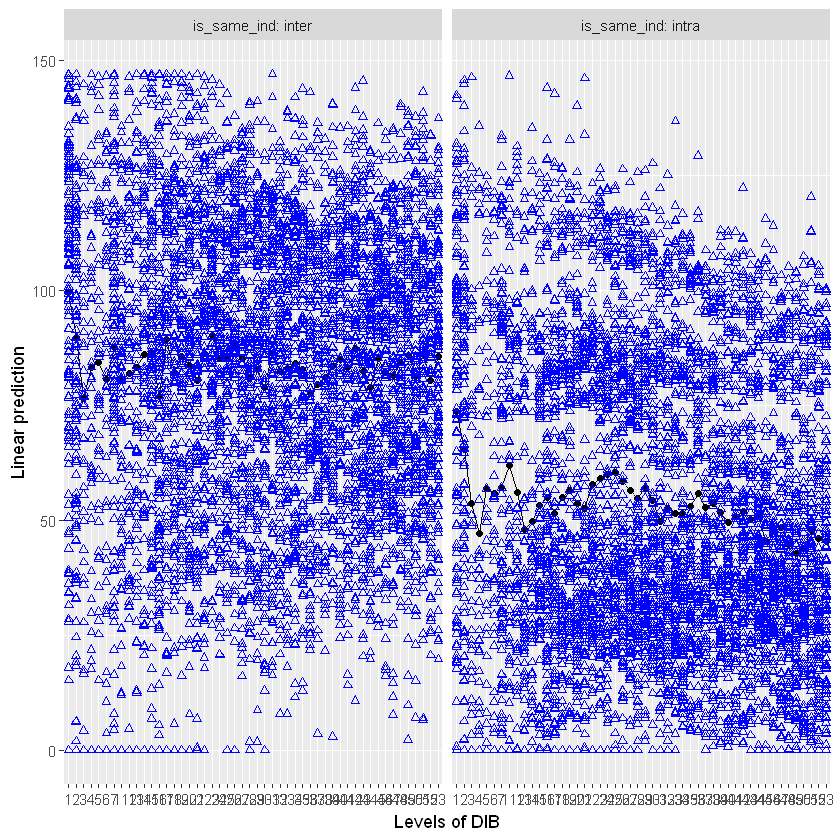

In [35]:
emmip(fit, ~ DIB | is_same_ind, CIs = FALSE) +
    geom_point(aes(x = DIB, y = DTW_15_5_Zone), data = df, pch = 2, color = "blue")

In [29]:
#the reference grid for this model (basis for EMM computations)
ref_grid(fit) #, pbkrtest.limit = 12000, lmerTest.limit = 12000)

 henID1_nbr_stays_5_Zone henID2_nbr_stays_5_Zone DIB is_same_ind is_MEXP
                       0                    5.21 1   inter       False  
                       1                    5.21 1   inter       False  
                       2                    5.21 1   inter       False  
                       3                    5.21 1   inter       False  
                       4                    5.21 1   inter       False  
                       5                    5.21 1   inter       False  
                       6                    5.21 1   inter       False  
                       7                    5.21 1   inter       False  
                       8                    5.21 1   inter       False  
                       9                    5.21 1   inter       False  
                      10                    5.21 1   inter       False  
                      11                    5.21 1   inter       False  
                      12                    5.21 1 

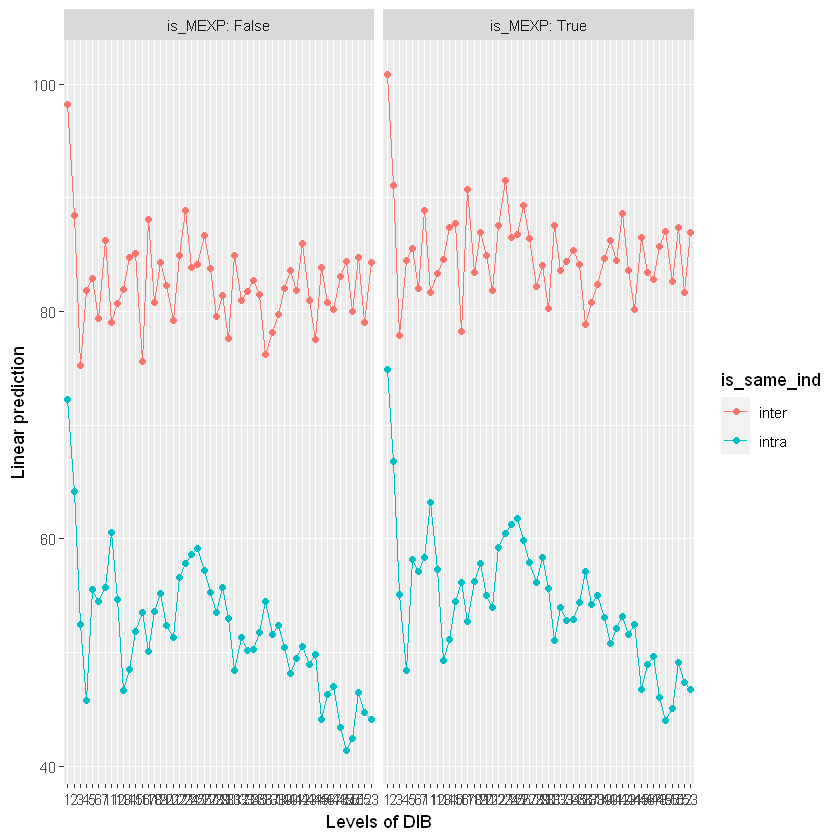

In [11]:
emmip(fit, is_same_ind ~ DIB | is_MEXP, pbkrtest.limit = 12000, lmerTest.limit = 12000)

In [12]:
emmip(fit, is_same_ind ~ DIB, plotit=FALSE, lmerTest.limit = 12000)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11905' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.



,is_same_ind,DIB,yvar,SE,df,tvar,xvar
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,inter,1,99.55206,3.017513,452.3945,inter,1
2,intra,1,73.59514,2.963735,421.9170,intra,1
3,inter,2,89.77145,2.975501,428.3836,inter,2
4,intra,2,65.44932,2.953900,416.4864,intra,2
5,inter,3,76.56882,4.723548,2251.7600,inter,3
6,intra,3,53.73332,4.711643,2230.9669,intra,3
7,inter,4,83.12215,4.731822,2264.6844,inter,4
8,intra,4,47.07741,4.712211,2231.5898,intra,4
9,inter,5,84.22566,4.549063,1993.0174,inter,5


In [15]:
#estimate the mean at each point in the reference grid
emmip(fit, DIB)

ERROR: Error in .all.vars(form): objet 'DIB' introuvable


In [ ]:
#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_5_Zone ~ henID1_nbr_stays_5_Zone + henID2_nbr_stays_5_Zone + DIB*is_same_ind + is_MEXP + Treatment + (1|PenID/henID1), data=df)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)
emmip(fit, DIB ~ is_same_ind)#, pbkrtest.limit = 12000)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11905' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11905' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.



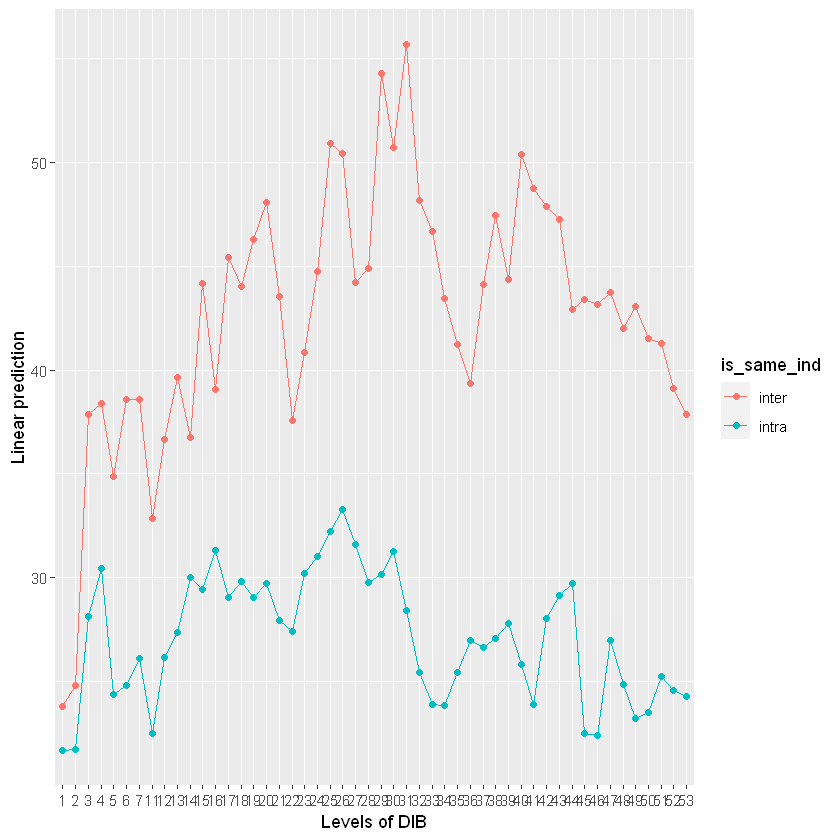

In [34]:
#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_4_Zone ~ henID1_nbr_stays_4_Zone + henID2_nbr_stays_4_Zone + DIB*is_same_ind + is_MEXP + Treatment + (1|PenID/henID1), data=df)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
emmip(fit, is_same_ind ~ DIB)#, pbkrtest.limit = 12000)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11905' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11905' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.



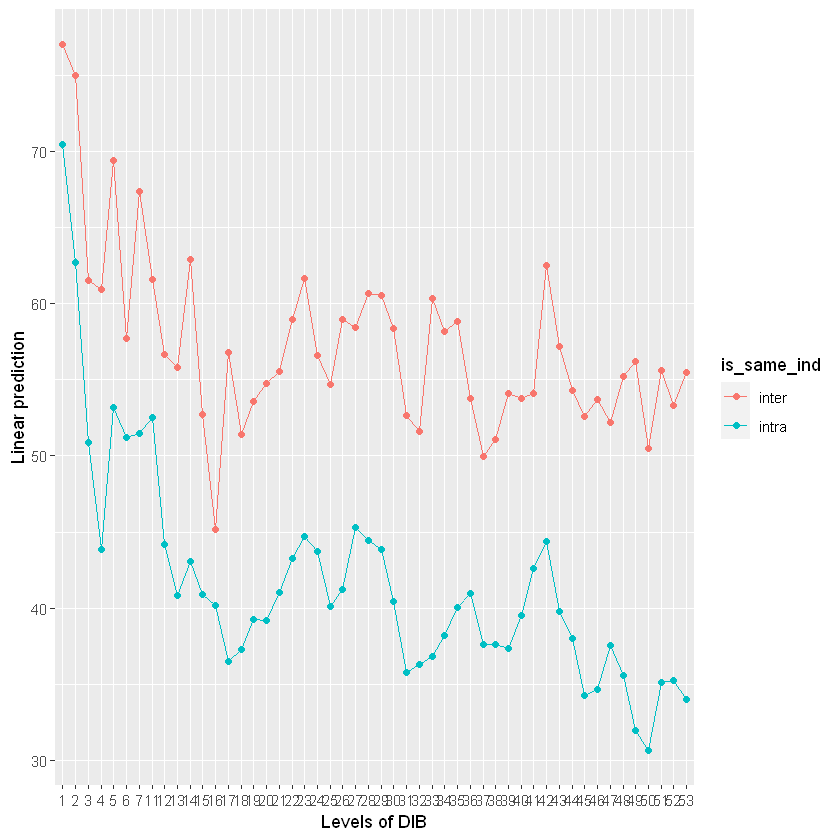

In [26]:
#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_3_Zone ~ henID1_nbr_stays_3_Zone + henID2_nbr_stays_3_Zone + DIB*is_same_ind + is_MEXP + Treatment + (1|PenID/henID1), data=df)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
emmip(fit, is_same_ind ~ DIB)#, pbkrtest.limit = 12000)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11905' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11905' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.



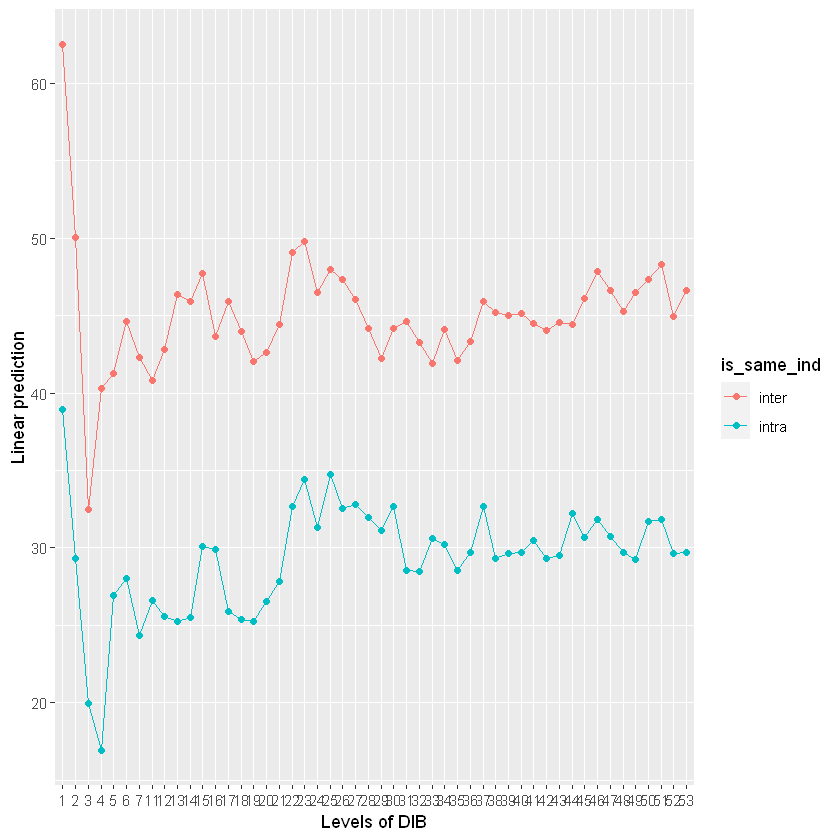

In [27]:
#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_2_Zone ~ henID1_nbr_stays_2_Zone + henID2_nbr_stays_2_Zone + DIB*is_same_ind + is_MEXP + Treatment + (1|PenID/henID1), data=df)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
emmip(fit, is_same_ind ~ DIB)#, pbkrtest.limit = 12000)

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11905' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 11905' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.



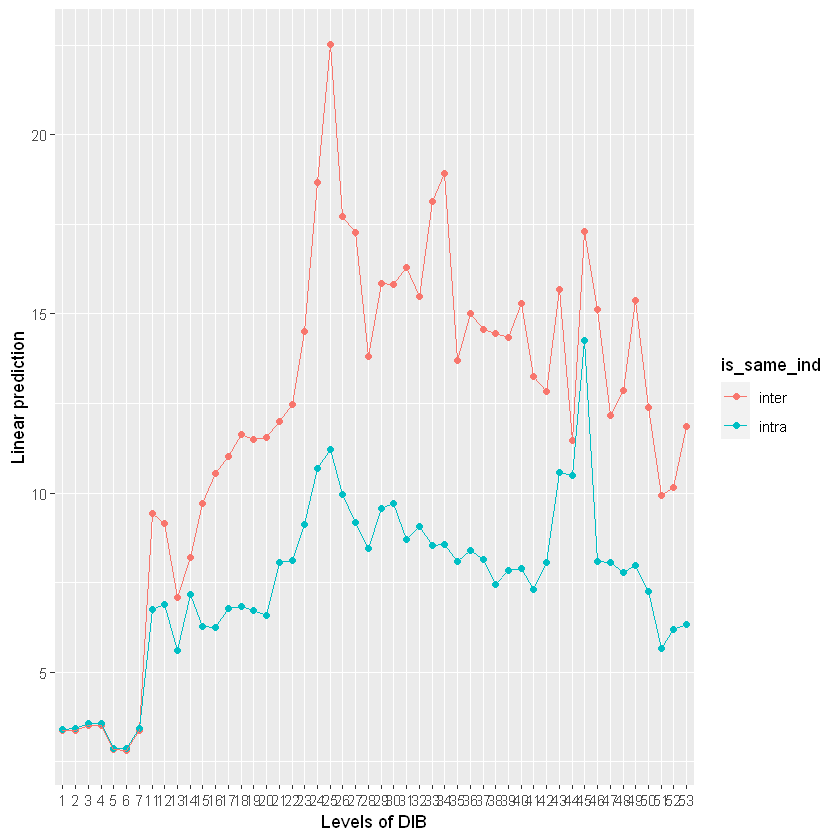

In [28]:
#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_1_Zone ~ henID1_nbr_stays_1_Zone + henID2_nbr_stays_1_Zone + DIB*is_same_ind + is_MEXP + Treatment + (1|PenID/henID1), data=df)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
emmip(fit, is_same_ind ~ DIB)#, pbkrtest.limit = 12000)

In [ ]:
#does not converge with: (1|PenID/henID2)
fit = lmer(chi2distance ~ henID1_Total_number_transition + henID2_Total_number_transition + DOA*is_same_ind + is_MEXP + Treatment + (1|PenID/henID1), data=df)
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)

#weeks in the laying barn
#does not converge with: (1|PenID/henID2)
fit = lmer(DTW_15_3_Zone ~ henID1_Total_number_transition + henID2_Total_number_transition + weeks_in_laying_barn*is_same_ind + Treatment + is_MEXP + (1|PenID/henID1)+(1|DOA), data=df)
#Hence, this boils down to comparing the variation between different PenID (having 7 degrees of freedom) to the variation 
#due to the interaction between Trackingsystem_Zone and HenID (having  5*159=795  degrees of freedom).
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)

#one model per DOA
#does not converge with: (1|PenID/henID2)
df_DOA = subset(df, DOA == 140)
print(dim(df_DOA))
#head(df_DOA1, 3)
fit = lmer(DTW_15_3_Zone ~ henID1_Total_number_transition + henID2_Total_number_transition + is_same_ind + Treatment + is_MEXP + (1|PenID), data=df_DOA)
#Hence, this boils down to comparing the variation between different PenID (having 7 degrees of freedom) to the variation 
#due to the interaction between Trackingsystem_Zone and HenID (having  5*159=795  degrees of freedom).
#capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)

In [ ]:
emmip(fit, is_same_ind ~ DOA)#, pbkrtest.limit = 12000)

In [87]:
M = emmeans(fit, pairwise ~ DOA : is_same_ind, lmerTest.limit = 12000, adjust = "bonf")

Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 11905' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 11905)' or larger];
but be warned that this may result in large computation time and memory use.



In [88]:
summary(M, adjust = "tukey")

Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



,DOA,is_same_ind,emmean,SE,df,lower.CL,upper.CL
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,119,inter,0.3974294,0.01637300,489.1736,0.3401677,0.4546910
2,120,inter,0.4327130,0.01613063,461.7923,0.3762765,0.4891494
3,121,inter,0.3330901,0.02550442,2365.1515,0.2443658,0.4218145
4,122,inter,0.3931566,0.02553950,2376.5299,0.3043108,0.4820024
5,123,inter,0.3632069,0.02458762,2095.5753,0.2776566,0.4487571
6,124,inter,0.3336048,0.02460197,2100.7609,0.2480050,0.4192047
7,125,inter,0.3678842,0.01612441,461.2218,0.3114690,0.4242994
8,129,inter,0.3032117,0.01961207,959.2851,0.2348470,0.3715764
9,130,inter,0.3527733,0.01962815,962.1216,0.2843533,0.4211934


In [89]:
Anova(fit)

,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
henID1_Total_number_transition,34.192091,1,4.993148e-09
henID2_Total_number_transition,11.297827,1,7.759786e-04
DOA,325.965737,49,1.477552e-42
is_same_ind,4138.890920,1,0.000000e+00
is_MEXP,1.110251,1,2.920274e-01
Treatment,0.157007,1,6.919272e-01
DOA:is_same_ind,202.601114,49,1.413404e-20


In [90]:
#rand: Likelihood Ratio Test On Random Effects Of Linear Mixed Effects Model
#tests the hypothesis that the random effect variation is significant versus the null that there is no between group-level 
#variation
rand(fit)
#ranef(fit)
#confint(fit)

,npar,logLik,AIC,LRT,Df,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,107,3777.787,-7341.574,NA,NA,NA
(1 | henID1:PenID),106,3740.609,-7269.218,74.35600,1,6.522687e-18
(1 | PenID),106,3772.599,-7333.198,10.37549,1,1.276996e-03


# Assumptions

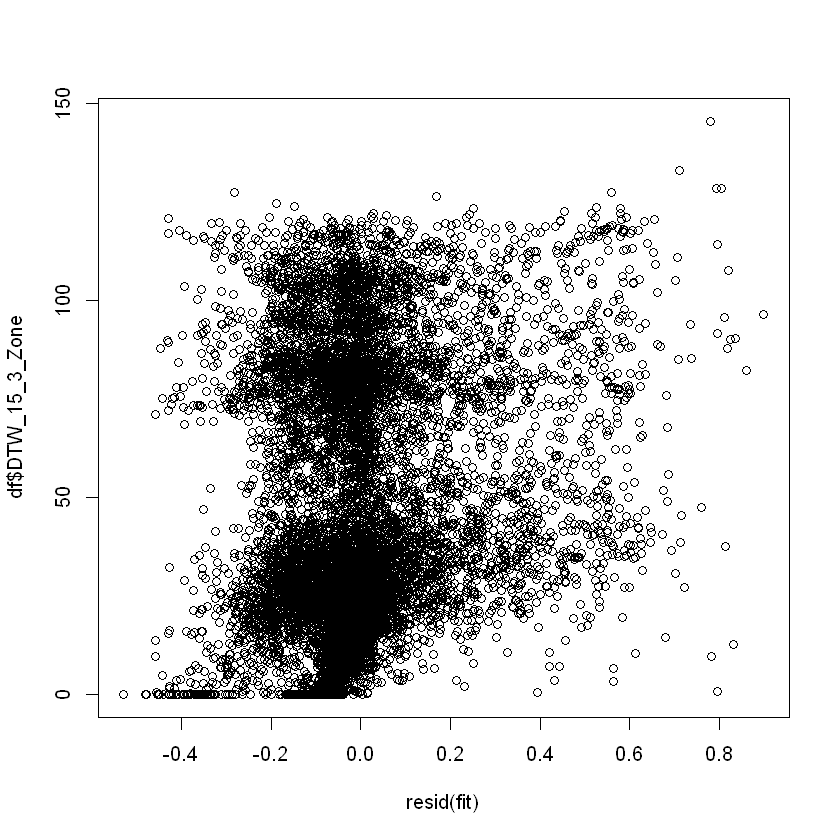

In [92]:
#linearity
#jpeg(file.path(path_, paste('diagnostic_plot_linearity_',name,'.jpg', sep='')))
plot(resid(fit),df$DTW_15_3_Zone)
#dev.off()

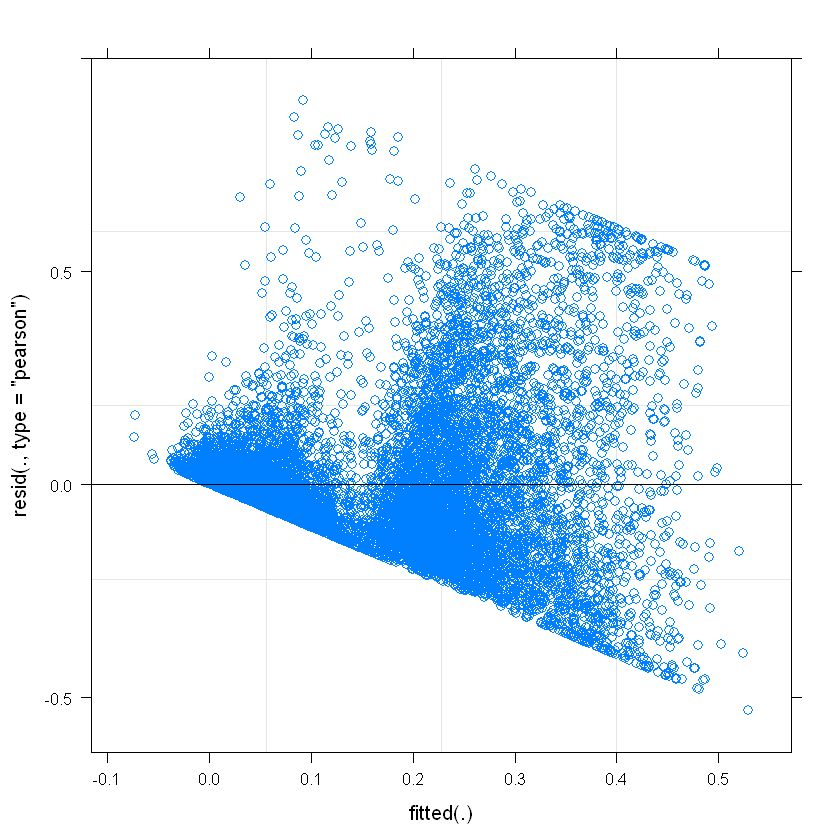

In [93]:
#check homogeneity of variance
#variance of the residuals is equal across groups
plot(fit)

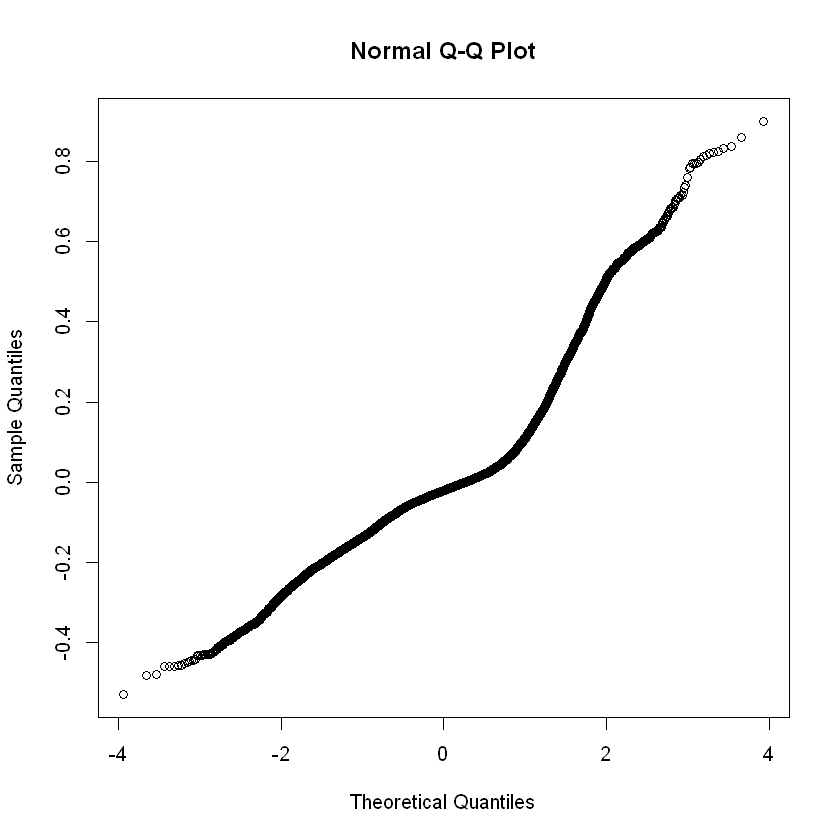

In [94]:
#normally distributed residuals
#qqmath(fit) #same
qqnorm(resid(fit))

$`henID1:PenID`

$PenID


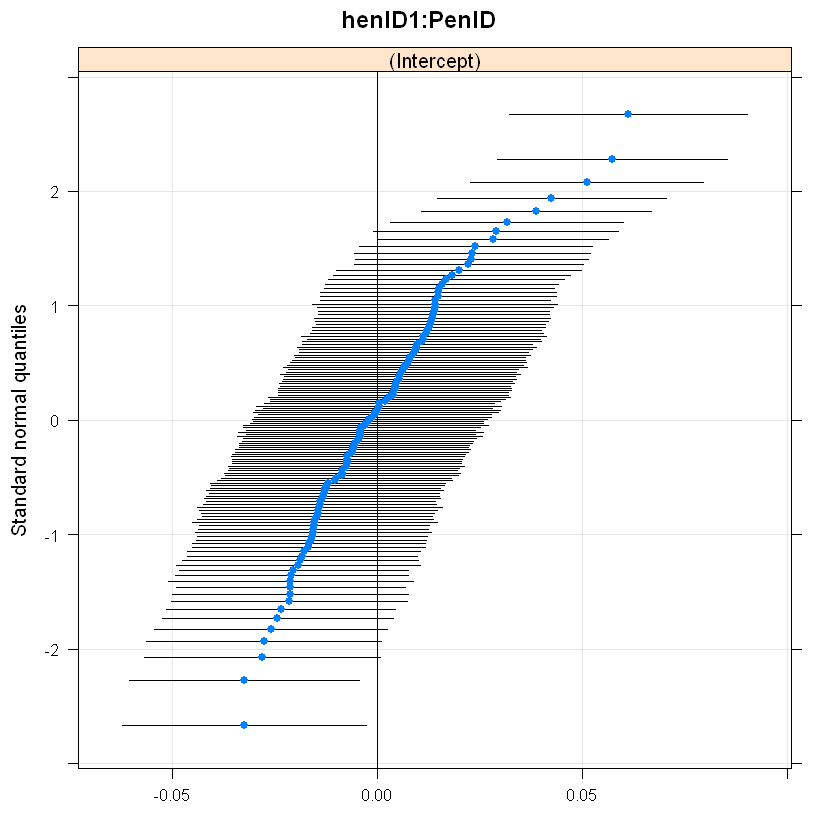

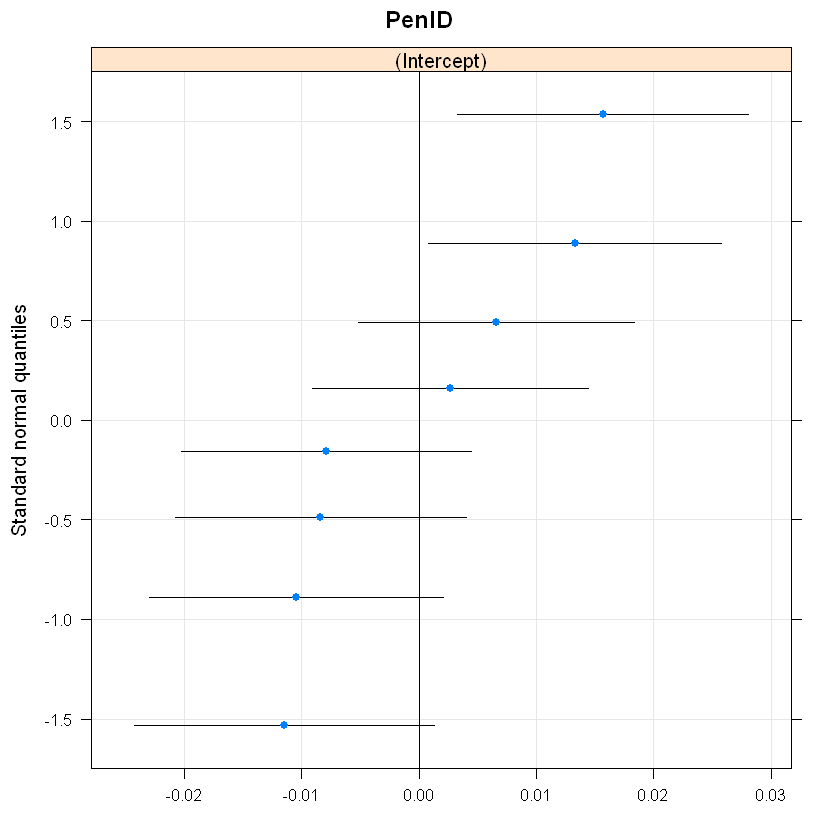

In [95]:
#qqplot
qqmath(ranef(fit))

### Linearity assumption

In [ ]:
qplot(year, lifeExp, data = gapminder.sub, main = paste("Life expectancy in", country.name)) +
  geom_smooth(method = "lm")

`geom_smooth()` using formula 'y ~ x'



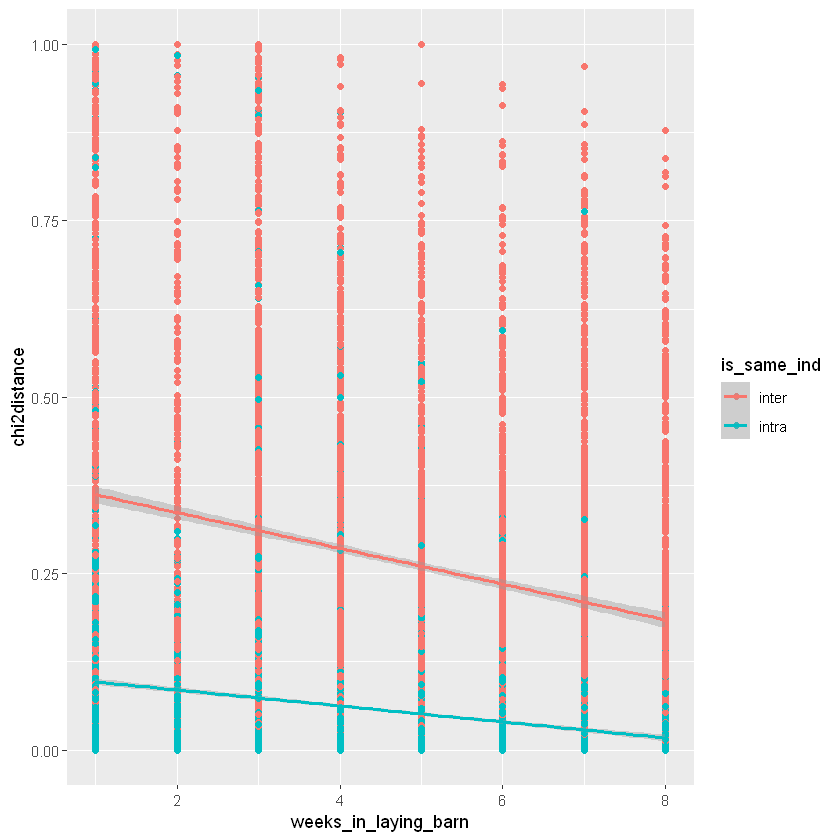

In [82]:
qplot(x = weeks_in_laying_barn, y = chi2distance, color = is_same_ind, data = df) +
  stat_smooth(method = "lm", se = TRUE, fullrange = TRUE)

`geom_smooth()` using formula 'y ~ x'



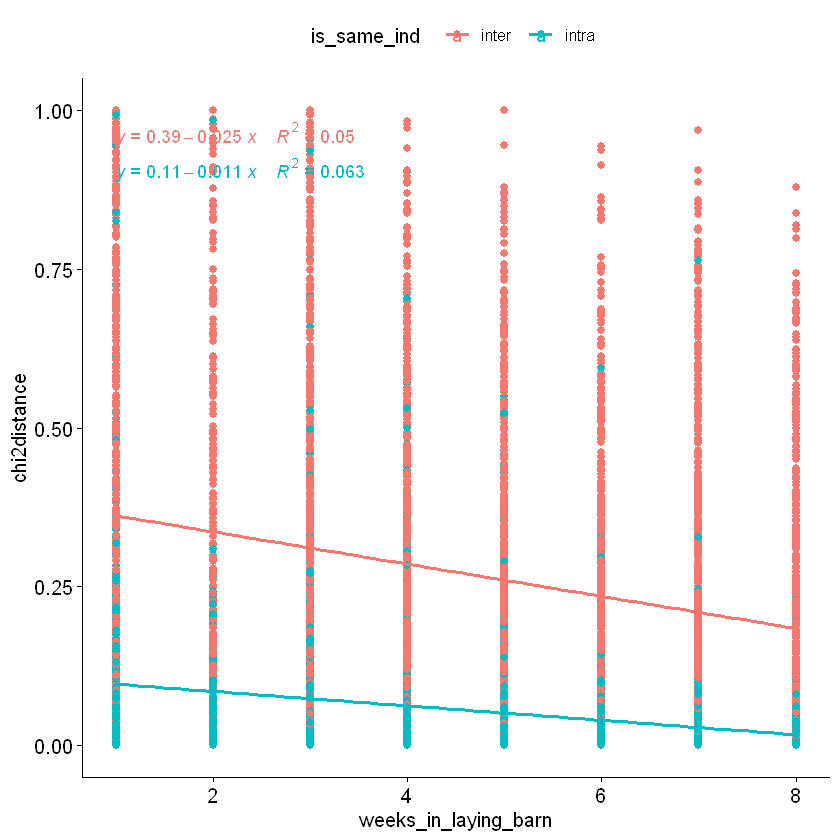

In [85]:
ggscatter(
  df, x = "weeks_in_laying_barn", y = "chi2distance",
  color = "is_same_ind", add = "reg.line"
  )+
  stat_regline_equation(
    aes(label =  paste(..eq.label.., ..rr.label.., sep = "~~~~"), color = is_same_ind)
    )

### Homogeneity of regression slopes

In [4]:
df %>% anova_test(SQRTPercentagenotmoving ~ Treatment*DOA)

Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,Treatment,1,52,31.343,8.23e-07,*,0.376000
2,DOA,1,52,136.758,3.56e-16,*,0.725000
3,Treatment:DOA,1,52,0.016,9.00e-01,,0.000305


### Normality of residuals

In [5]:
# Fit the model, the covariate goes first
model <- lm(SQRTPercentagenotmoving ~ DOA + Treatment, data = df)
# Inspect the model diagnostic metrics
model.metrics <- augment(model)
head(model.metrics, 3)

SQRTPercentagenotmoving,DOA,Treatment,.fitted,.resid,.hat,.sigma,.cooksd,.std.resid
<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.288690,119,OFH,6.276508,1.012182,0.08706841,0.8599265,0.04777896,1.225936
7.806247,119,TRAN,4.971391,2.834856,0.08706841,0.7692652,0.37478458,3.433526
4.677072,120,OFH,6.121666,-1.444594,0.08041887,0.8470026,0.08859416,-1.743329


In [6]:
# Assess normality of residuals using shapiro wilk test
shapiro_test(model.metrics$.resid)

variable,statistic,p.value
<chr>,<dbl>,<dbl>
model.metrics$.resid,0.9746566,0.2845212


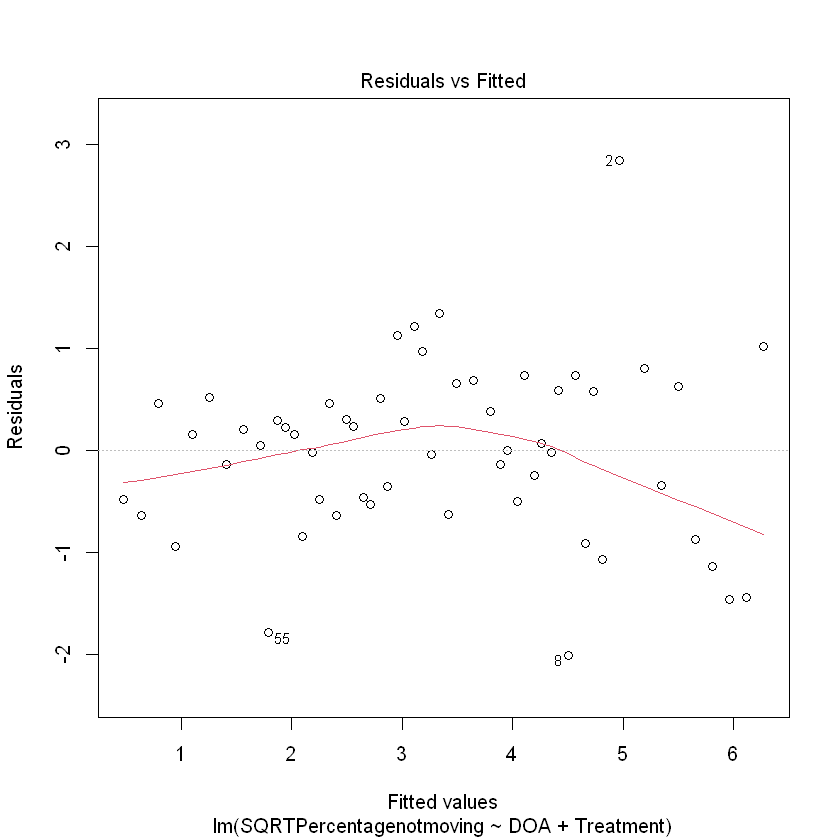

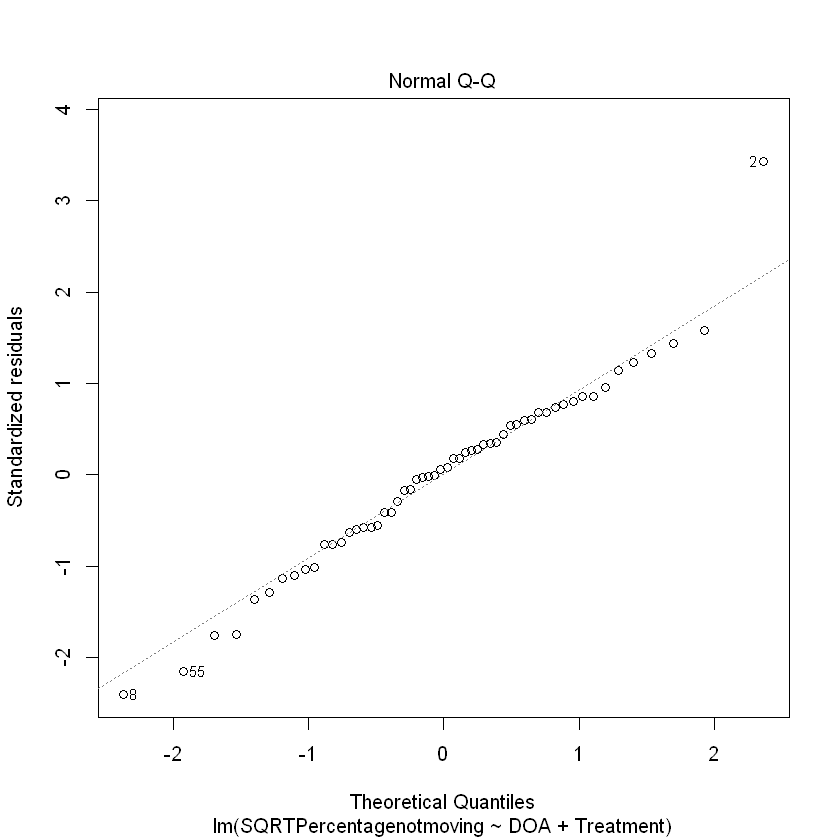

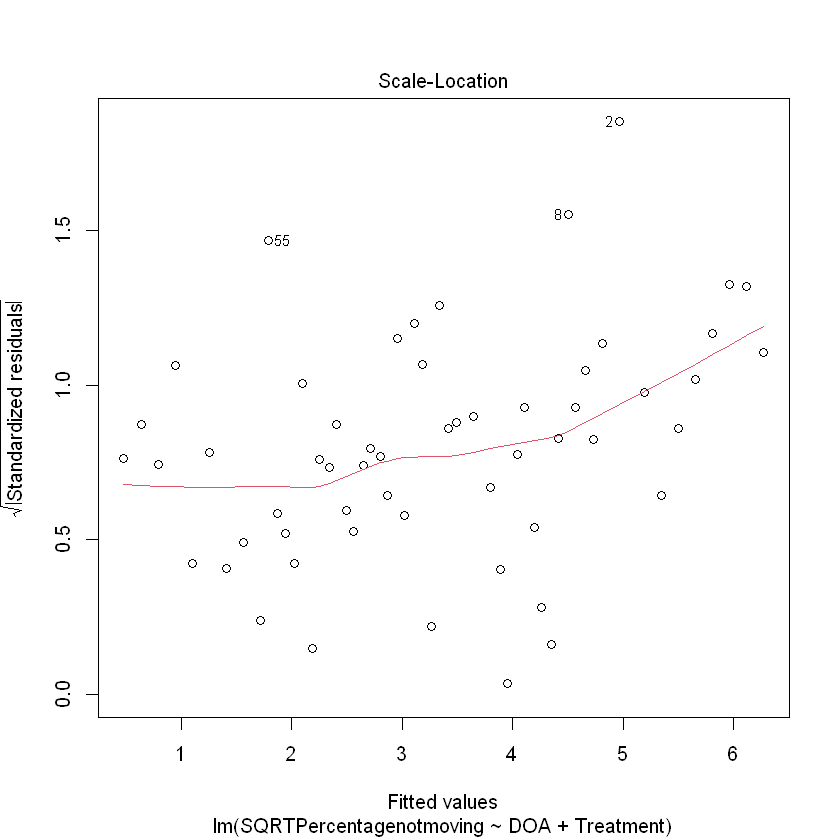

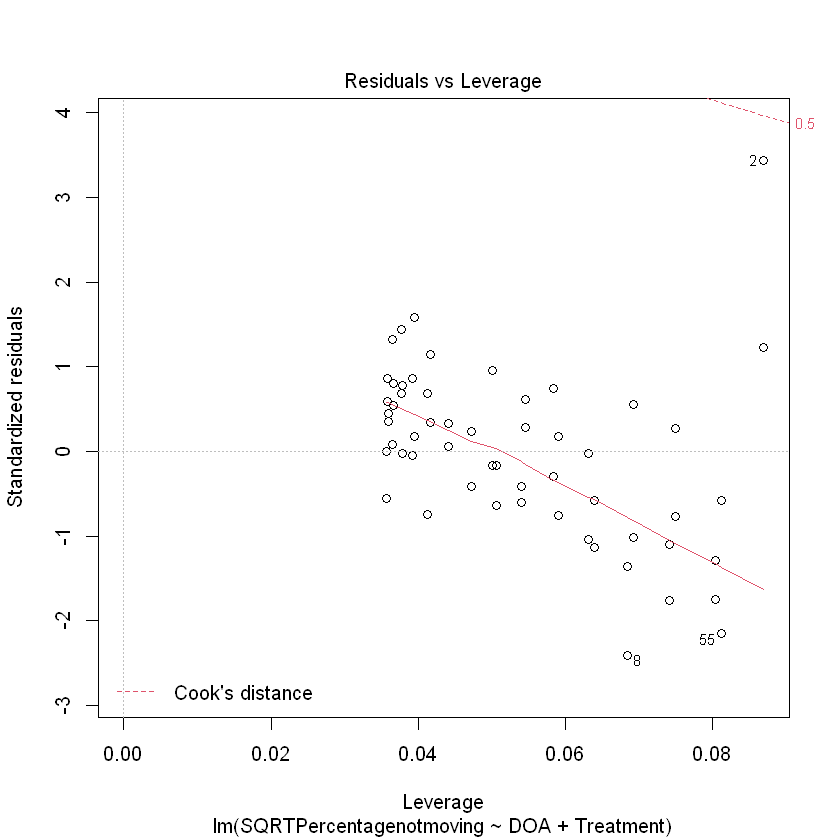

In [7]:
plot(model)

### Homogeneity of variances

In [14]:
leveneTest(.resid ~ Treatment, data=model.metrics)

Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,0.3975178,0.5310332
,54,NA,NA


### outliers

In [15]:
model.metrics %>% 
  filter(abs(.std.resid) > 3) %>%
  as.data.frame()

SQRTPercentagenotmoving,DOA,Treatment,.fitted,.resid,.hat,.sigma,.cooksd,.std.resid
<dbl>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.806247,119,TRAN,4.971391,2.834856,0.08706841,0.7692652,0.3747846,3.433526


There is one outliers in the data the first day, should I remove it?

# ANCOVA

In [16]:
res.aov <- df %>% anova_test(SQRTPercentagenotmoving ~ DOA + Treatment)
get_anova_table(res.aov)

Coefficient covariances computed by hccm()



,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,DOA,1,53,139.346,1.86e-16,*,0.724
2,Treatment,1,53,31.936,6.46e-07,*,0.376


In [23]:
summary(res.aov)

    Effect               DFn         DFd           F         
 Length:2           Min.   :1   Min.   :53   Min.   : 31.94  
 Class :character   1st Qu.:1   1st Qu.:53   1st Qu.: 58.79  
 Mode  :character   Median :1   Median :53   Median : 85.64  
                    Mean   :1   Mean   :53   Mean   : 85.64  
                    3rd Qu.:1   3rd Qu.:53   3rd Qu.:112.49  
                    Max.   :1   Max.   :53   Max.   :139.35  
       p                p<.05                ges       
 Min.   :0.000e+00   Length:2           Min.   :0.376  
 1st Qu.:1.615e-07   Class :character   1st Qu.:0.463  
 Median :3.230e-07   Mode  :character   Median :0.550  
 Mean   :3.230e-07                      Mean   :0.550  
 3rd Qu.:4.845e-07                      3rd Qu.:0.637  
 Max.   :6.460e-07                      Max.   :0.724  

In [17]:
emmeans_test(SQRTPercentagenotmoving ~ Treatment, covariate = DOA, data=df, p.adjust.method = "bonferroni")

ERROR: Error: Column name `std.error` must not be duplicated.


In [18]:
pwc <- df %>% 
  emmeans_test(
    SQRTPercentagenotmoving ~ Treatment, covariate = DOA,
    p.adjust.method = "bonferroni"
    )
pwc

ERROR: Error: Column name `std.error` must not be duplicated.


In [19]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 18363)

Matrix products: default

locale:
[1] LC_COLLATE=French_Switzerland.1252  LC_CTYPE=French_Switzerland.1252   
[3] LC_MONETARY=French_Switzerland.1252 LC_NUMERIC=C                       
[5] LC_TIME=French_Switzerland.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] car_3.0-10      carData_3.0-4   reshape2_1.4.4  emmeans_1.5.4  
 [5] lmerTest_3.1-3  WRS2_1.1-0      rstatix_0.6.0   ggpubr_0.4.0   
 [9] broom_0.7.4     lme4_1.1-26     Matrix_1.2-18   modEvA_2.0     
[13] MASS_7.3-53     leaps_3.1       caret_6.0-86    lattice_0.20-41
[17] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.3     purrr_0.3.4    
[21] readr_1.4.0     tidyr_1.1.2     tibble_3.0.6    ggplot2_3.3.3  
[25] tidyverse_1.3.0 lindia_0.9      DHARMa_0.3.3.0 

loaded via a namespace (and not attached):
 [1] minqa_1.2.4      